#LIMPIEZA DE DATOS

In [44]:
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

class InsuranceDataProcessor:
    def __init__(self, input_path, output_path):
        """
        Inicializa la clase con las rutas de entrada y salida.
        """
        self.input_path = input_path
        self.output_path = output_path
        self.data = None
        self.cleaned_data = None

    def load_data(self):
        """
        Carga el dataset desde la ruta especificada.
        """
        self.data = pd.read_csv(self.input_path, header=None)
        print("Datos cargados correctamente.")
        print(self.data.head(20))

    def clean_data(self):
        """
        Limpia los datos: convierte columnas object a numéricas y maneja valores nulos.
        """
        print("Forma original:", self.data.shape)
        print(self.data.info())
        print(self.data.describe(include='all').T)

        for col in self.data.columns:
            if self.data[col].dtype == 'object':
                self.data[col] = pd.to_numeric(self.data[col], errors='coerce')
                self.data[col] = self.data[col].round().astype('Int64')

        self.data.fillna(value=np.nan, inplace=True)
        nulos_pre = self.data.isnull().mean() * 100
        print("Porcentaje de nulos por columna:")
        print(nulos_pre.sort_values(ascending=False))

        # Eliminar la última columna
        last_col = self.data.columns[-1]
        self.data.drop(columns=[last_col], inplace=True)
        print(f"Última columna eliminada: {last_col}")


    def validate_target_variable(self):
        """
        Valida la variable de salida (última columna) y elimina registros inválidos.
        """
        target_col = self.data.columns[-1]

        null_count = self.data[target_col].isnull().sum()
        null_percentage = (null_count / len(self.data)) * 100
        print(f"Número de valores nulos en la variable de salida: {null_count}")
        print(f"Porcentaje de nulos en la variable de salida: {null_percentage:.2f}%")

        # Eliminar registros con valores nulos en la variable objetivo
        self.data.dropna(subset=[target_col], inplace=True)

        # Validar que la variable objetivo solo tenga valores 0 o 1
        invalid_values_count = self.data[~self.data[target_col].isin([0, 1])].shape[0]
        invalid_values_percentage = (invalid_values_count / len(self.data)) * 100
        print(f"Número de valores en la variable de salida que no son 0 ni 1: {invalid_values_count}")
        print(f"Porcentaje de valores en la variable de salida que no son 0 ni 1: {invalid_values_percentage:.2f}%")

        # Filtrar solo registros válidos
        self.data = self.data[self.data[target_col].isin([0, 1])]

    def export_data(self):
        """
        Exporta el dataset limpio a la ruta especificada.
        """
        self.data.to_csv(self.output_path, index=False)
        print(f"Datos exportados correctamente a {self.output_path}.")

    def load_clean_data(self, input_path):
        """
        Carga el dataset desde la ruta especificada.
        """
        self.data = pd.read_csv(self.input_path, header=None)
        print("Datos limpios cargados correctamente.")
        print(self.data.head(20))

    def load_clean_data(self):
        """
        Guarda el dataset limpio en una variable aparte.
        """
        self.cleaned_data = self.data.copy()
        print("Dataset limpio guardado en la variable 'cleaned_data'.")
        print(self.cleaned_data.head(20))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#EDA

In [45]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

class InsuranceEDA:
    def __init__(self, data: pd.DataFrame):
        self.data = data

    def analyze_missing_values(self):
        print("=== Análisis de valores nulos por columna ===")
        nulos = self.data.isnull().mean() * 100
        print(nulos.sort_values(ascending=False))

        print("\n=== Filas con más del 5% de valores nulos ===")
        porcentaje_nulos_por_fila = self.data.isnull().mean(axis=1) * 100
        porcentajes_filtrados = porcentaje_nulos_por_fila[porcentaje_nulos_por_fila >= 5]
        print(f"Número de filas con >=5% nulos: {len(porcentajes_filtrados)}")
        print(porcentajes_filtrados.sort_values(ascending=False))

    def analyze_outliers(self):
        print("=== Análisis de valores extremos por columna ===")
        plt.figure(figsize=(15, 8))
        self.data.boxplot()
        plt.title('Boxplot de todas las variables')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    def analyze_distributions(self):
        cols_per_row = 4
        total_cols = len(self.data.columns)
        rows = math.ceil(total_cols / cols_per_row)

        fig, axes = plt.subplots(rows, cols_per_row, figsize=(cols_per_row * 4, rows * 3))
        axes = axes.flatten()

        for i, col in enumerate(self.data.columns):
            sns.histplot(self.data[col], kde=True, bins=30, color='skyblue', ax=axes[i])
            axes[i].set_title(f'Distribución de: {col}')
            axes[i].set_xlabel('')
            axes[i].set_ylabel('')

        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])

        plt.tight_layout()
        plt.show()

    def analyze_skewness(self):
        skew_values = self.data.skew()
        filtered_skew = skew_values[(skew_values > 1) | (skew_values < -1)]
        sorted_skew = filtered_skew.sort_values(ascending=False)
        print("=== Variables con sesgo significativo (>|1|) ===")
        print(sorted_skew)

    def analyze_target_correlation(self):
        target_col = self.data.columns[-1]
        cols_per_row = 4
        total_cols = len(self.data.columns) - 1
        rows = math.ceil(total_cols / cols_per_row)

        fig, axes = plt.subplots(rows, cols_per_row, figsize=(cols_per_row * 4, rows * 3))
        axes = axes.flatten()

        for i, col in enumerate(self.data.columns[:-1]):
            sns.boxplot(x=self.data[target_col], y=self.data[col], ax=axes[i])
            axes[i].set_title(f'Correlación entre objetivo y {col}')
            axes[i].set_xlabel('')
            axes[i].set_ylabel('')

        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])

        plt.tight_layout()
        plt.show()

    def analyze_correlation_matrix(self):
        plt.figure(figsize=(10, 8))
        sns.heatmap(self.data.corr(), annot=False, cmap='coolwarm', linewidths=0.5, cbar_kws={'shrink': 0.5})
        plt.title('Matriz de Correlaciones')
        plt.xticks(rotation=90, fontsize=8)
        plt.yticks(rotation=0, fontsize=8)
        plt.tight_layout()
        plt.show()

#FEATURE ENGINNERING

In [46]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt


class MedianOutlierHandler(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        """
        Calcula las medianas y los límites para detección de outliers usando IQR.
        También guarda las medianas para imputación de valores nulos.
        """
        self.medians_ = X.median()
        self.bounds_ = {}
        for col in X.columns:
            Q1 = X[col].quantile(0.25)
            Q3 = X[col].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - 1.5 * IQR
            upper = Q3 + 1.5 * IQR
            self.bounds_[col] = (lower, upper)
        return self

    def transform(self, X):
        """
        Imputa valores nulos con la mediana y reemplaza outliers por la mediana.
        """
        X_copy = X.copy()
        for col in X_copy.columns:
            median = self.medians_[col]
            lower, upper = self.bounds_[col]
            # Imputación de nulos
            X_copy[col] = X_copy[col].fillna(median)
            # Reemplazo de outliers
            X_copy[col] = X_copy[col].apply(lambda x: median if x < lower or x > upper else x)
        return X_copy


class CorrelationRemover(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        corr_matrix = X.corr().abs()
        upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        self.to_drop_ = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.75)]
        return self

    def transform(self, X):
        return X.drop(columns=self.to_drop_, errors='ignore')

class InsurancePipeline:
    def __init__(self, df: pd.DataFrame):
        self.df = df.copy()
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.pipeline = None
        self.n_components_90 = None

    def preprocess(self):
        # Eliminación de duplicados
        self.df = self.df.drop_duplicates()

        # Filtrado por porcentaje de nulos (<=5%)
        porcentaje_nulos_por_fila = self.df.isnull().mean(axis=1) * 100
        self.df = self.df[porcentaje_nulos_por_fila <= 5]

        # Separar X e y
        X = self.df.iloc[:, :-1]
        y = self.df.iloc[:, -1]

        # División train/test
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Construcción del pipeline
        self.pipeline = Pipeline([
            ('outlier_handler', MedianOutlierHandler()),
            ('corr_remover', CorrelationRemover()),
            ('scaler', StandardScaler()),
            ('pca', PCA())  # PCA inicial para determinar componentes
        ])

        # Ajustar pipeline en X_train
        X_train_transformed = self.pipeline.fit_transform(self.X_train)

        # Determinar número de componentes para explicar >=90% varianza
        cumulative_variance = np.cumsum(self.pipeline.named_steps['pca'].explained_variance_ratio_)
        self.n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1

        print(f"Número de componentes necesarios para explicar ≥90% de la varianza: {self.n_components_90}")

        # Graficar PCA
        plt.plot(cumulative_variance * 100)
        plt.title('PCA Analysis')
        plt.xlabel('N-th Principal Component')
        plt.ylabel('% Cumulative Variance Explained')
        plt.axhline(y=90, color='r', linestyle='--', linewidth=1)
        plt.axvline(x=self.n_components_90 - 1, color='r', linestyle='--', linewidth=1)
        plt.show()

        # Ajustar PCA con n_components_90
        self.pipeline.named_steps['pca'].n_components = self.n_components_90
        X_train_final = self.pipeline.fit_transform(self.X_train)
        X_test_final = self.pipeline.transform(self.X_test)

        return X_train_final, X_test_final, self.y_train, self.y_test

#ENTRENAMIENTO Y EVALUACIÓN

In [47]:
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

class ModelTrainerEvaluator:
    def __init__(self, X_train, X_test, y_train, y_test):
        """
        Inicializa la clase con los conjuntos de entrenamiento y prueba.
        """
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.results = {}

    def show_class_distribution(self):
        """
        Muestra la distribución de clases en el conjunto de entrenamiento.
        """
        dist = self.y_train.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
        print(f"Distribución de clases:\n{dist}")

    def correlation_with_target(self):
        """
        Calcula la correlación de las variables independientes con la variable objetivo.
        """
        df = pd.concat([pd.DataFrame(self.X_train), pd.Series(self.y_train, name='target')], axis=1)
        corr = abs(df.corr()['target'].sort_values(ascending=False))
        print("Correlación con la variable dependiente:\n", corr)

    def apply_smote(self):
        """
        Aplica SMOTE para balancear las clases en el conjunto de entrenamiento.
        """
        smote = SMOTE(random_state=42)
        X_resampled, y_resampled = smote.fit_resample(self.X_train, self.y_train)
        return X_resampled, y_resampled
    def train_and_evaluate(self, model_name, model):
        """
        Entrena y evalúa un modelo, mostrando matriz de confusión y reporte de clasificación.
        """
        # Aplicar SMOTE
        X_resampled, y_resampled = self.apply_smote()

        # Entrenar el modelo
        model.fit(X_resampled, y_resampled)

        # Predicción
        y_pred = model.predict(self.X_test)

        # Matriz de confusión
        cm = confusion_matrix(self.y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred 0', 'Pred 1'], yticklabels=['Real 0', 'Real 1'])
        plt.title(f'Matriz de Confusión - {model_name}')
        plt.show()

        # Reporte de clasificación
        report = classification_report(self.y_test, y_pred, zero_division=0, output_dict=True)
        print(f"\nReporte de clasificación - {model_name}:")
        print(classification_report(self.y_test, y_pred, zero_division=0))

        # Guardar resultados
        self.results[model_name] = report

    def run_model(self, model):
        """
        Ejecuta el entrenamiento y evaluación para el modelo.
        """

        # Obtener el nombre del modelo dinámicamente
        model_name = model.__class__.__name__

        self.train_and_evaluate(model_name, model)

In [48]:
processor = InsuranceDataProcessor(
    input_path='/content/drive/MyDrive/Colab Notebooks/MLOps/Tarea Fase 1/insurance_company_modified.csv',
    output_path='/content/drive/My Drive/Colab Notebooks/MLOps/Tarea Fase 2/insurance_clean.csv'
)

processor.load_data()
processor.clean_data()
processor.validate_target_variable()
processor.export_data()

Datos cargados correctamente.
        0      1      2      3     4    5      6      7    8      9   ...  \
0       33      1      3      2     8    0      5    1.1  3.1      7  ...   
1    37.0     1.0    2.0    2.0   8.0  1.0    4.0      ?  4.0   6.0   ...   
2     37.0    1.0    2.0    2.0   8.0  0.0    4.0    2.0  4.0    3.0  ...   
3      9.0    1.0    3.0    3.0   3.0  2.0    3.0   2.0   4.0    5.0  ...   
4     40.0    1.0    4.0    2.0  10.0  1.0    4.0    1.0  4.0    7.0  ...   
5    23.0     1.0    2.0    1.0   5.0  0.0    5.0    0.0  5.0    0.0  ...   
6     39.0   2.0     3.0    2.0   9.0  2.0    2.0   0.0   5.0    7.0  ...   
7     33.0    1.0    2.0    3.0   8.0  0.0    7.0    0.0  2.0  196.0  ...   
8     33.0    1.0    2.0    4.0   8.0  0.0    1.0    3.0  6.0    6.0  ...   
9     11.0    2.0    3.0    3.0   3.0  3.0   5.0     0.0  2.0    7.0  ...   
10    10.0    1.0    4.0    3.0   3.0  1.0    4.0    1.0  NaN    NaN  ...   
11     9.0    1.0    3.0   3.0    3.0  1.0    

In [49]:
processor.load_clean_data()
insurance = processor.cleaned_data

Dataset limpio guardado en la variable 'cleaned_data'.
     0   1   2   3   4   5   6     7     8     9   ...  76  77  78  79    80  \
0    33   1   3   2   8   0   5     1     3     7  ...   0   0   0   1     0   
1    37   1   2   2   8   1   4  <NA>     4     6  ...   0   0   0   1  <NA>   
2    37   1   2   2   8   0   4     2     4     3  ...   0   0   0   1     0   
3     9   1   3   3   3   2   3     2     4     5  ...   0   0   0   1     0   
4    40   1   4   2  10   1   4     1     4     7  ...   0   0   0   1     0   
5    23   1   2   1   5   0   5     0     5     0  ...   0   0   0   0     0   
6    39   2   3   2   9   2   2     0     5     7  ...   0   0   0   0     0   
7    33   1   2   3   8   0   7     0     2   196  ...   0   0   0   0     0   
8    33   1   2   4   8   0   1     3     6     6  ...   0   0   0   0     0   
9    11   2   3   3   3   3   5     0     2     7  ...   0   0   0   1     0   
10   10   1   4   3   3   1   4     1  <NA>  <NA>  ...   0   0   

=== Análisis de valores nulos por columna ===
58    1.894266
73    1.877045
13    1.842604
25    1.773721
55    1.773721
        ...   
76    1.171001
81    1.136559
31    1.119339
32    1.102118
85    0.000000
Length: 86, dtype: float64

=== Filas con más del 5% de valores nulos ===
Número de filas con >=5% nulos: 55
5658    8.139535
648     6.976744
704     6.976744
2392    6.976744
2670    6.976744
2257    6.976744
912     6.976744
3100    6.976744
4434    6.976744
5846    6.976744
4676    6.976744
1328    5.813953
1334    5.813953
1475    5.813953
1573    5.813953
588     5.813953
830     5.813953
986     5.813953
1278    5.813953
565     5.813953
399     5.813953
605     5.813953
94      5.813953
2219    5.813953
2193    5.813953
2142    5.813953
2035    5.813953
1915    5.813953
1878    5.813953
1827    5.813953
1760    5.813953
2781    5.813953
3094    5.813953
3469    5.813953
3489    5.813953
2340    5.813953
2276    5.813953
2662    5.813953
2240    5.813953
4092    5.813953


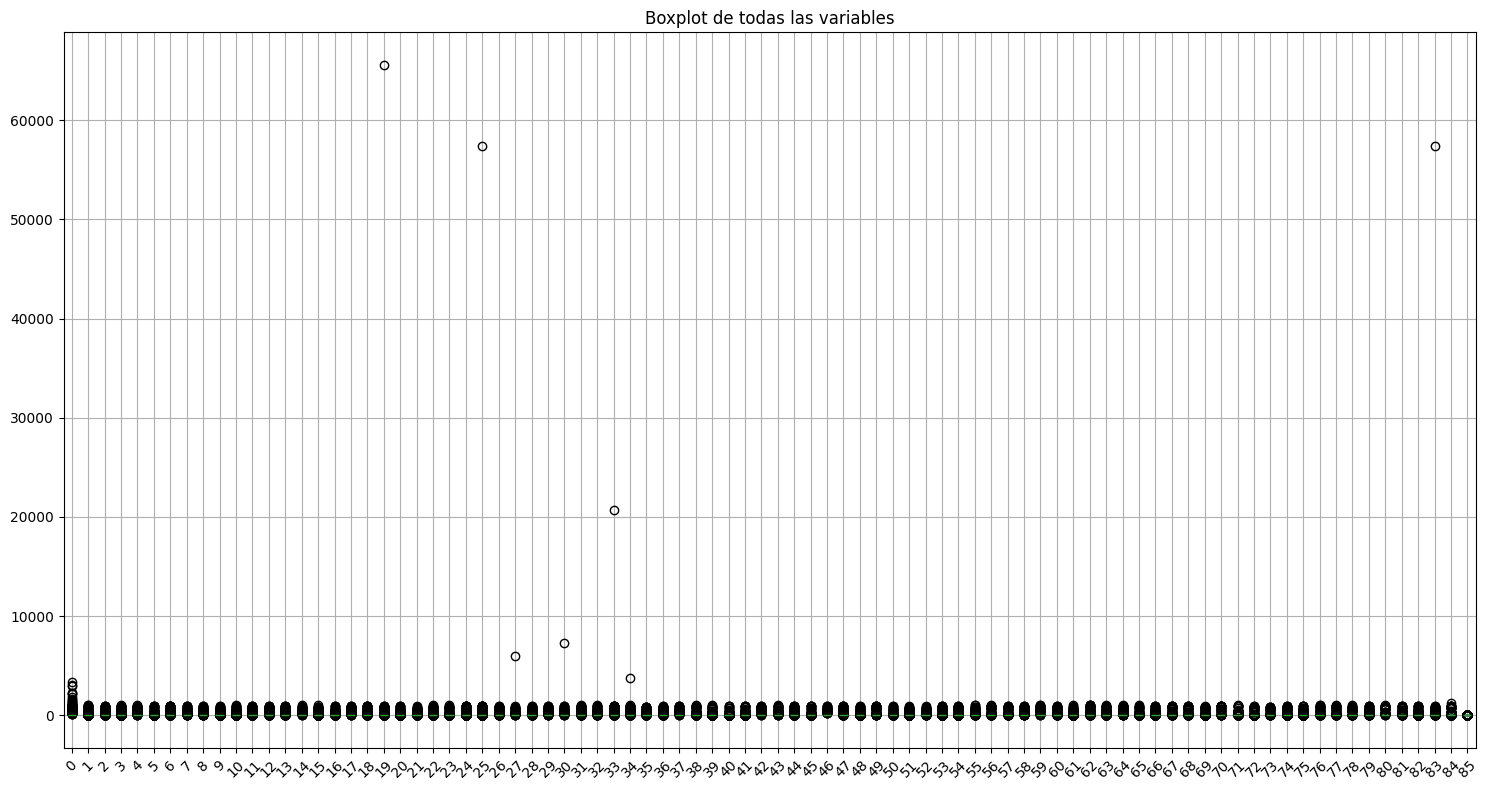

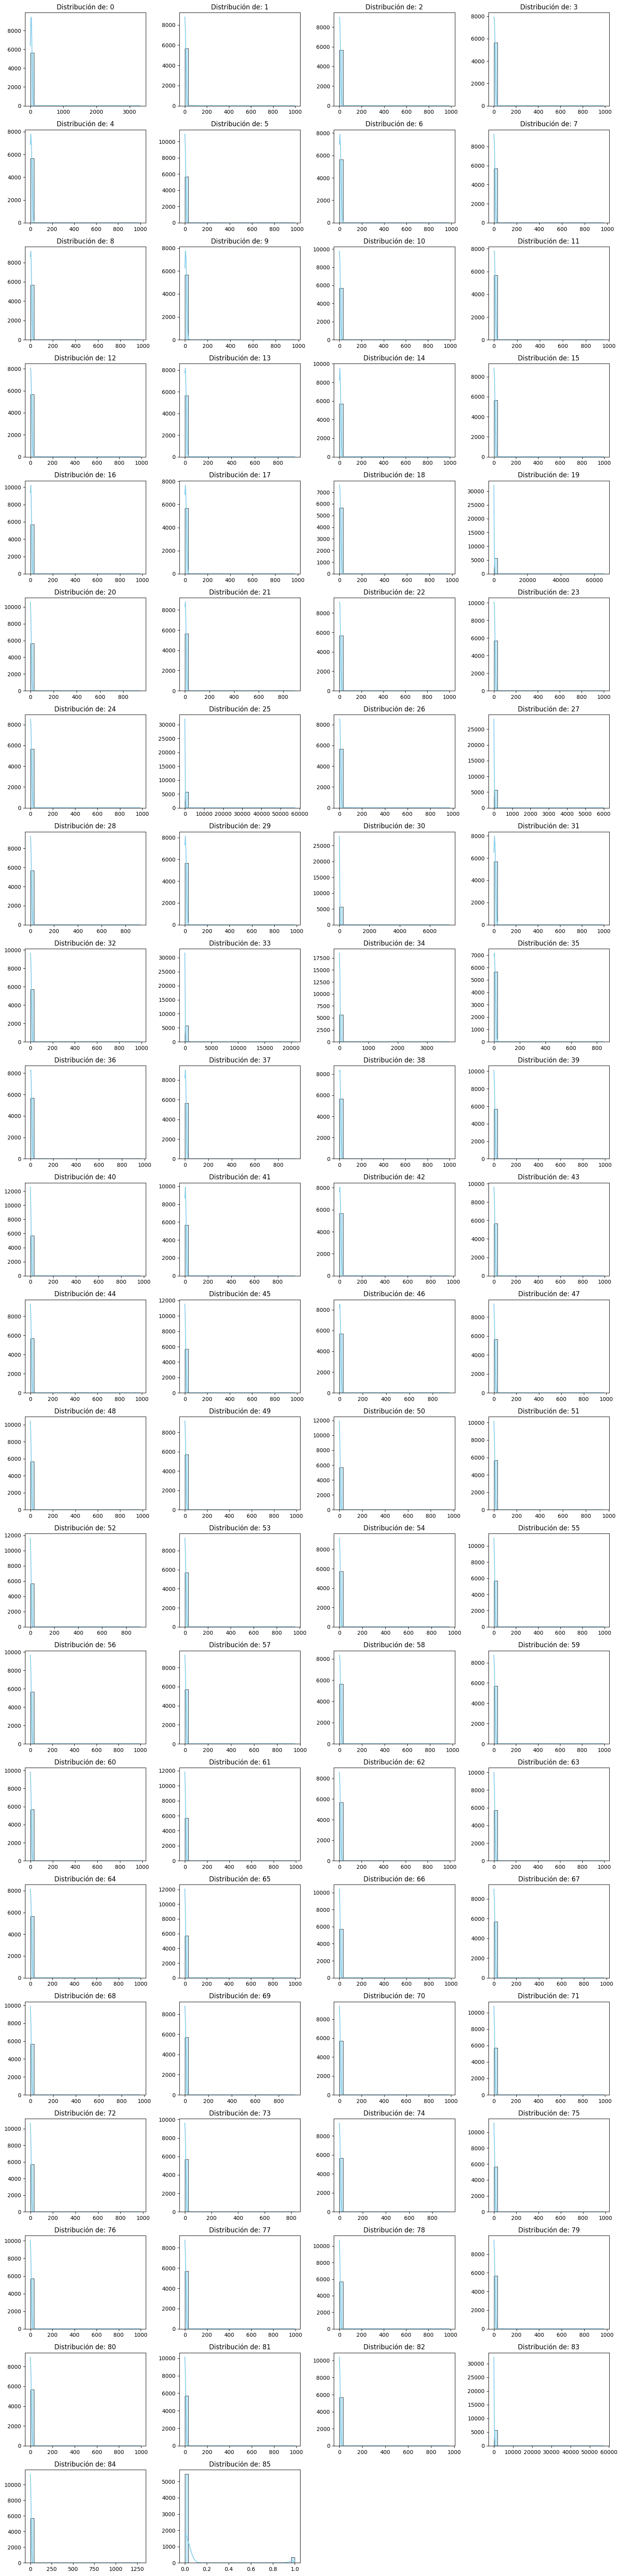

=== Variables con sesgo significativo (>|1|) ===
83    75.345972
19    75.277885
25    75.005182
33    71.625414
27    58.413281
        ...    
35    13.518927
17    13.411716
4     13.400012
9      11.97137
85     3.689922
Length: 86, dtype: Float64


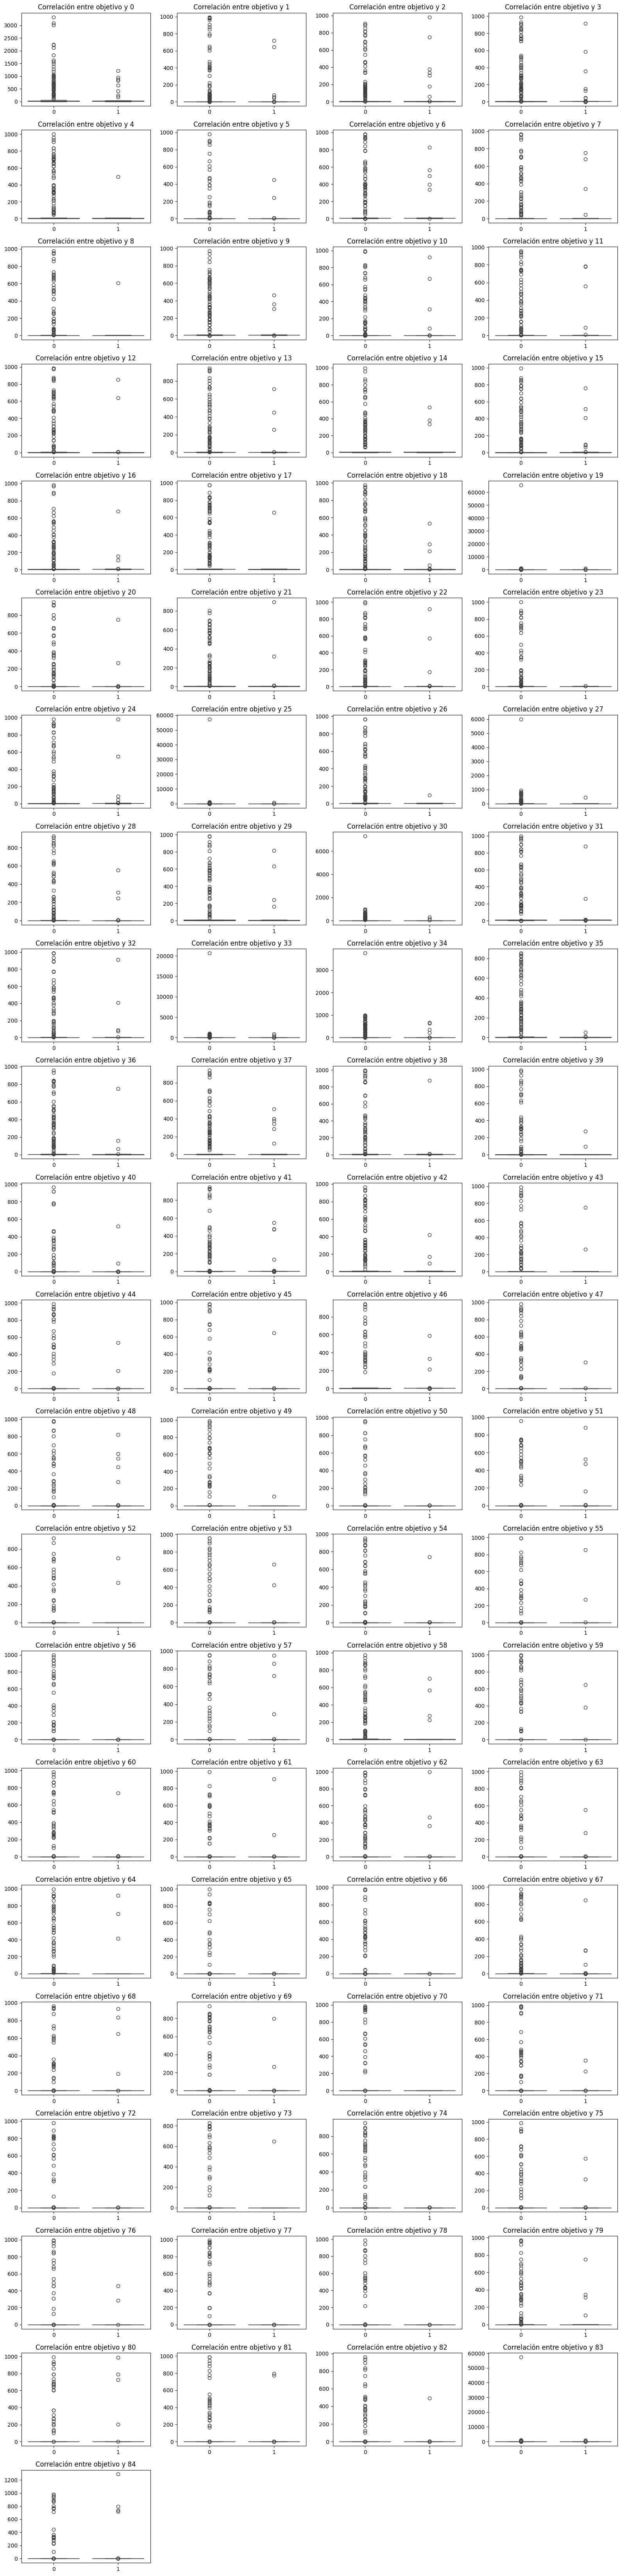

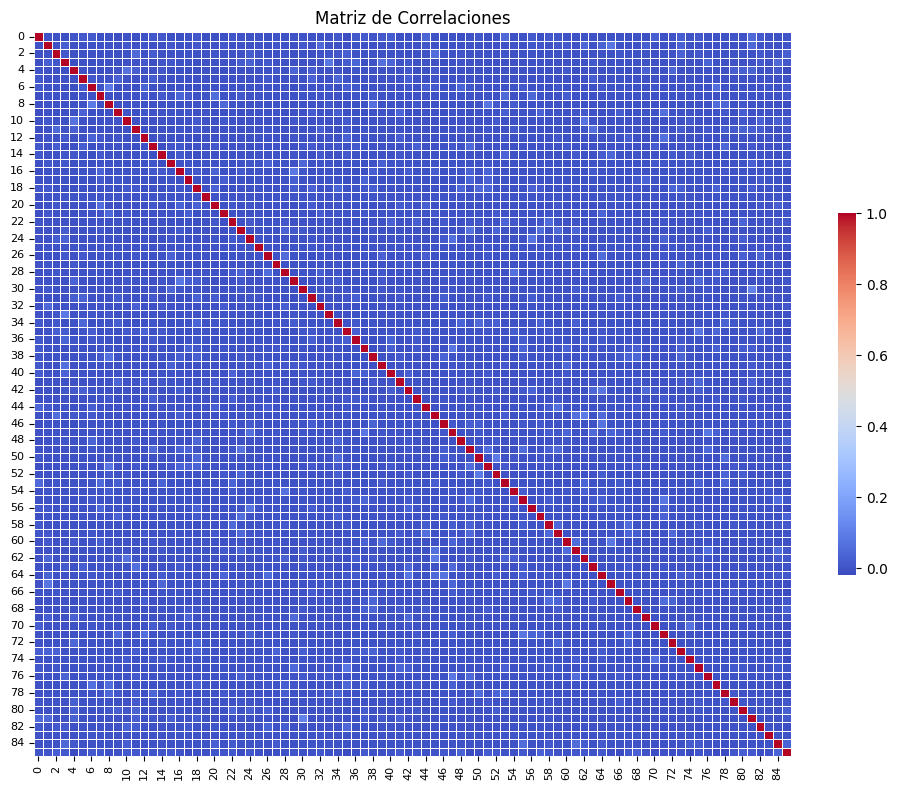

In [50]:
eda = InsuranceEDA(insurance)
eda.analyze_missing_values()
eda.analyze_outliers()
eda.analyze_distributions()
eda.analyze_skewness()
eda.analyze_target_correlation()
eda.analyze_correlation_matrix()

Número de componentes necesarios para explicar ≥90% de la varianza: 26


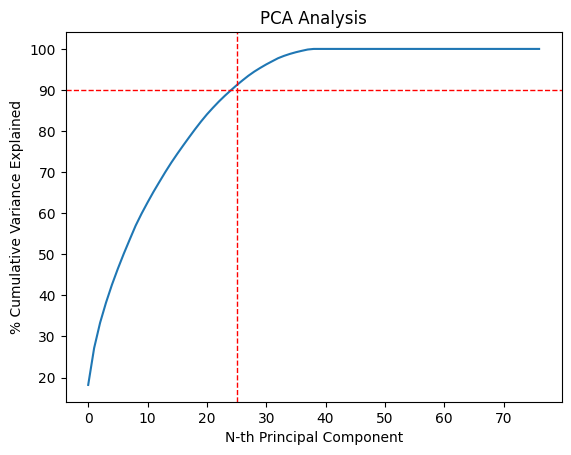

In [51]:
pipeline = InsurancePipeline(insurance)
X_train_final, X_test_final, y_train, y_test = pipeline.preprocess()

Distribución de clases:
85
0    94.1%
1     5.9%
Name: proportion, dtype: object
Correlación con la variable dependiente:
 target    1.000000
21        0.028615
19        0.023094
4         0.022155
13        0.019267
5         0.014451
22        0.010183
11        0.010007
14        0.008846
24        0.008587
9         0.007752
20        0.000593
7         0.002356
8         0.008721
18        0.009286
2         0.009742
15        0.010233
17        0.012865
3         0.015578
6         0.015843
10        0.016008
12        0.018725
0         0.019771
23        0.019868
16        0.022534
1         0.027432
25        0.034848
Name: target, dtype: float64


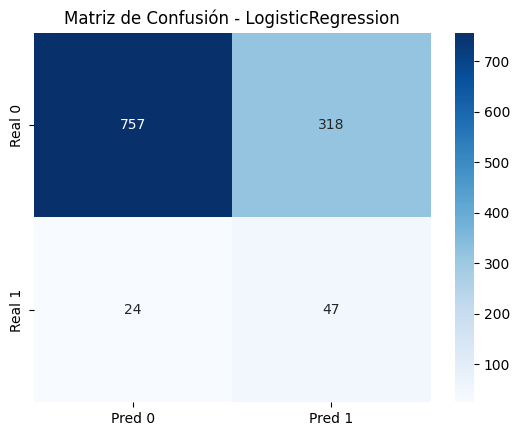


Reporte de clasificación - LogisticRegression:
              precision    recall  f1-score   support

         0.0       0.97      0.70      0.82      1075
         1.0       0.13      0.66      0.22        71

    accuracy                           0.70      1146
   macro avg       0.55      0.68      0.52      1146
weighted avg       0.92      0.70      0.78      1146



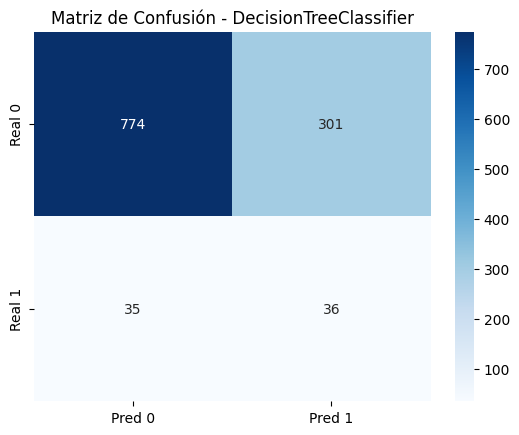


Reporte de clasificación - DecisionTreeClassifier:
              precision    recall  f1-score   support

         0.0       0.96      0.72      0.82      1075
         1.0       0.11      0.51      0.18        71

    accuracy                           0.71      1146
   macro avg       0.53      0.61      0.50      1146
weighted avg       0.90      0.71      0.78      1146



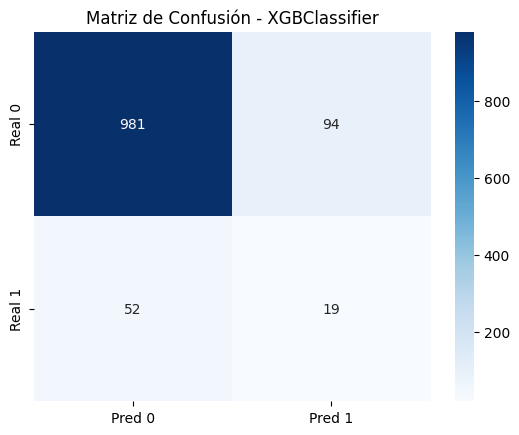


Reporte de clasificación - XGBClassifier:
              precision    recall  f1-score   support

         0.0       0.95      0.91      0.93      1075
         1.0       0.17      0.27      0.21        71

    accuracy                           0.87      1146
   macro avg       0.56      0.59      0.57      1146
weighted avg       0.90      0.87      0.89      1146



In [52]:
trainer = ModelTrainerEvaluator(X_train_final, X_test_final, y_train, y_test)

trainer.show_class_distribution()
trainer.correlation_with_target()

for model in [LogisticRegression(max_iter=1000, class_weight='balanced'),
              DecisionTreeClassifier(max_depth=10, random_state=42, class_weight='balanced'),
              XGBClassifier(n_estimators=500,
                            max_depth=8,
                            learning_rate=0.1,
                            scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]),
                            colsample_bytree=1,
                            subsample= 0.8,
                            random_state=42,
                            eval_metric='aucpr')]:
  trainer.run_model(model)